In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import plotly.express as px
from datetime import timedelta
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from pathlib import Path
from sklearn.metrics import adjusted_rand_score

In [151]:
# Initialize workflow parameters
num_top = 50
data_path = Path(f'../data/top_{num_top}_companies_by_sector.csv').resolve()
analysis_start = "2024-01-01"
analysis_end = "2025-05-15"
data = pd.read_csv(data_path)
data

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap (B),Country,IPO Year,Volume,Sector,Industry
0,UFPI,UFP Industries Inc. Common Stock,$115.67,-0.7900,-0.678%,7.024022,United States,1993.0,223820,Basic Materials,Forest Products
1,AMWD,American Woodmark Corporation Common Stock,$77.01,0.4800,0.627%,1.159322,United States,1986.0,168642,Basic Materials,Forest Products
2,IPX,IperionX Limited American Depositary Share,$26.52,0.1200,0.455%,0.682213,United States,NaN,50560,Basic Materials,Other Metals and Minerals
3,EU,enCore Energy Corp. Common Shares,$2.91,0.0600,2.105%,0.541518,United States,NaN,1091464,Basic Materials,Other Metals and Minerals
4,USGO,U.S. GoldMining Inc. Common stock,$12.59,1.7800,16.466%,0.156678,United States,2023.0,225247,Basic Materials,Precious Metals
...,...,...,...,...,...,...,...,...,...,...,...
524,VIVK,Vivakor Inc. Common Stock,$0.845,-0.0248,-2.851%,0.028424,United States,NaN,42549,Utilities,Environmental Services
525,SONM,Sonim Technologies Inc. Common Stock,$2.55,-0.0800,-3.042%,0.012423,United States,2019.0,15396,Utilities,Telecommunications Equipment
526,CLRO,ClearOne Inc. (DE) Common Stock,$0.4926,-0.0072,-1.441%,0.011807,United States,NaN,87213,Utilities,Telecommunications Equipment
527,SUNE,SUNation Energy Inc. Common Stock,$1.225,-0.0950,-7.197%,0.002223,United States,NaN,87057,Utilities,Telecommunications Equipment


In [152]:
ticker = data['Symbol'].to_list()
company_name_ticker = data[['Name', 'Symbol']]
market_ticker = '^GSPC'
ticker.append(market_ticker)
company_name_ticker

,Name,Symbol
0,UFP Industries Inc. Common Stock,UFPI
1,American Woodmark Corporation Common Stock,AMWD
2,IperionX Limited American Depositary Share,IPX
3,enCore Energy Corp. Common Shares,EU
4,U.S. GoldMining Inc. Common stock,USGO
...,...,...
524,Vivakor Inc. Common Stock,VIVK
525,Sonim Technologies Inc. Common Stock,SONM
526,ClearOne Inc. (DE) Common Stock,CLRO
527,SUNation Energy Inc. Common Stock,SUNE


In [153]:
stock_price = yf.download(tickers=ticker, start = analysis_start, end = analysis_end)['Close'].dropna(axis = 1)
stock_price

[*********************100%***********************]  530 of 530 completed

21 Failed downloads:
['ARKOW', 'RMCOW', 'USGOW', 'ANNAW', 'DHCNL', 'AMODW', 'NIOBW', 'SLDPW', 'ZEOWW', 'HYMCW', 'DFLIW', 'NEHCW', 'NEOVW', 'NESRW', 'ADNWW', 'NXPLW', 'FOXXW', 'MVSTW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-01-01 -> 2025-05-15)')
['INFN', 'QRTEP', 'ROIC']: YFTzMissingError('possibly delisted; no timezone found')


Ticker,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,13.44,73.545906,184.290405,4.405,134.479996,7.980,3.92,580.070007,189.526352,6.600,...,37.200626,57.250000,267.980011,67.309998,11.26,56.220001,41.883701,69.150002,212.369995,4742.830078
2024-01-03,12.95,72.759689,182.910538,4.230,133.419998,7.950,3.89,571.789978,185.003098,6.150,...,36.628452,55.230000,252.520004,65.860001,11.28,53.980000,39.853088,67.169998,210.240005,4704.810059
2024-01-04,13.09,73.386681,180.587540,4.250,133.720001,7.640,3.82,567.049988,182.173630,6.000,...,36.250240,54.160000,252.970001,65.570000,11.27,52.750000,40.460377,66.900002,210.330002,4688.680176
2024-01-05,13.60,72.102859,179.862839,4.150,135.979996,8.000,3.84,564.599976,182.643570,5.910,...,35.901119,53.709999,252.690002,65.160004,11.27,52.430000,41.798298,66.959999,209.809998,4697.240234
2024-01-08,14.58,73.346863,184.210999,4.120,140.080002,7.950,3.89,580.549988,185.022690,5.940,...,36.153263,55.669998,261.089996,66.650002,11.28,54.580002,42.263256,68.389999,218.100006,4763.540039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,11.03,99.430000,197.231369,1.410,126.389999,3.975,3.54,383.989990,202.779999,3.340,...,32.689999,67.900002,265.369995,32.380001,1.60,66.750000,46.364128,80.250000,233.149994,5663.939941
2025-05-09,11.11,100.230003,198.270004,1.400,127.040001,4.400,3.77,383.279999,207.509995,2.800,...,32.790001,67.930000,266.709991,30.910000,1.67,66.779999,46.106380,81.309998,233.059998,5659.910156
2025-05-12,11.67,104.629997,210.789993,1.340,134.210007,4.940,3.89,395.940002,223.149994,2.740,...,32.099998,71.209999,300.109985,34.700001,1.57,70.080002,49.030781,82.669998,241.479996,5844.189941


In [154]:
returns = stock_price.pct_change().dropna()
ticker = [col for col in stock_price.columns if col != market_ticker]
stock_returns = returns[ticker]
market_returns = returns[market_ticker]
stock_returns

Ticker,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,-0.036458,-0.010690,-0.007487,-0.039728,-0.007882,-0.003759,-0.007653,-0.014274,-0.023866,-0.068182,...,0.015968,-0.015381,-0.035284,-0.057691,-0.021542,0.001776,-0.039844,-0.048482,-0.028633,-0.010030
2024-01-04,0.010811,0.008617,-0.012700,0.004728,0.002249,-0.038994,-0.017995,-0.008290,-0.015294,-0.024390,...,0.023576,-0.010326,-0.019374,0.001782,-0.004403,-0.000886,-0.022786,0.015238,-0.004020,0.000428
2024-01-05,0.038961,-0.017494,-0.004013,-0.023529,0.016901,0.047120,0.005236,-0.004321,0.002580,-0.015000,...,-0.007678,-0.009631,-0.008309,-0.001107,-0.006253,0.000000,-0.006066,0.033067,0.000897,-0.002472
2024-01-08,0.072059,0.017253,0.024175,-0.007229,0.030152,-0.006250,0.013021,0.028250,0.013026,0.005076,...,-0.015474,0.007023,0.036492,0.033242,0.022867,0.000887,0.041007,0.011124,0.021356,0.039512
2024-01-09,-0.013717,-0.013840,-0.002263,-0.007281,-0.003926,-0.015094,0.000000,0.009732,0.004127,0.010101,...,0.021611,-0.010998,-0.004131,-0.017810,-0.018305,0.000000,-0.004214,-0.011226,-0.001170,0.037414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,0.044508,0.038867,0.006319,0.052239,0.026559,-0.058057,0.153094,-0.002546,0.014610,-0.005952,...,0.062356,-0.014768,0.000295,0.031444,0.023712,-0.030303,0.004666,0.030403,0.020473,-0.001670
2025-05-09,0.007253,0.008046,0.005266,-0.007092,0.005143,0.106918,0.064972,-0.001849,0.023326,-0.161677,...,0.097826,0.003059,0.000442,0.005050,-0.045398,0.043750,0.000449,-0.005559,0.013209,-0.000386
2025-05-12,0.050405,0.043899,0.063146,-0.042857,0.056439,0.122727,0.031830,0.033031,0.075370,-0.021429,...,-0.014851,-0.021043,0.048285,0.125230,0.122614,-0.059880,0.049416,0.063427,0.016726,0.036128


In [155]:
sector_stocks = data[['Symbol', 'Sector']]
sector_stocks_cleaned = sector_stocks[sector_stocks['Symbol'].apply(lambda x: x in ticker)]
sector_stocks_cleaned_with_name = pd.merge(sector_stocks_cleaned, company_name_ticker, left_on='Symbol', right_on = 'Symbol')
sector_stocks_cleaned_with_name

,Symbol,Sector,Name
0,UFPI,Basic Materials,UFP Industries Inc. Common Stock
1,AMWD,Basic Materials,American Woodmark Corporation Common Stock
2,IPX,Basic Materials,IperionX Limited American Depositary Share
3,EU,Basic Materials,enCore Energy Corp. Common Shares
4,USGO,Basic Materials,U.S. GoldMining Inc. Common stock
...,...,...,...
494,VIVK,Utilities,Vivakor Inc. Common Stock
495,SONM,Utilities,Sonim Technologies Inc. Common Stock
496,CLRO,Utilities,ClearOne Inc. (DE) Common Stock
497,SUNE,Utilities,SUNation Energy Inc. Common Stock


In [156]:
residuals = pd.DataFrame(index=stock_returns.index)
for tick in ticker:
    Y = stock_returns[tick]
    X = sm.add_constant(market_returns)
    model = sm.OLS(Y, X).fit()
    residuals[tick] = model.resid
# calculating the residual return 
resid_corr = residuals.corr()
resid_corr

/var/folders/g5/7q0ynznx5hs03d9_7j1h1qbc0000gn/T/ipykernel_10027/1251507463.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/g5/7q0ynznx5hs03d9_7j1h1qbc0000gn/T/ipykernel_10027/1251507463.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/g5/7q0ynznx5hs03d9_7j1h1qbc0000gn/T/ipykernel_10027/1251507463.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
AAL,1.000000,0.045487,0.013940,0.062087,0.166405,0.018780,0.112186,-0.015802,0.123421,-0.038666,...,-0.015179,-0.021215,0.030480,0.231893,0.111321,-0.093232,0.034995,0.206322,0.033978,-0.027073
AAON,0.045487,1.000000,-0.244485,0.006797,-0.100677,0.032723,0.121121,-0.064526,-0.042473,-0.002442,...,0.004189,0.018463,0.014137,0.128257,0.110078,0.001088,0.012347,0.072648,0.034495,0.071909
AAPL,0.013940,-0.244485,1.000000,0.022736,0.032831,0.009755,0.022072,-0.025251,0.022509,-0.025850,...,-0.020584,-0.009894,-0.016633,-0.035815,0.020581,0.079602,-0.017742,-0.110755,0.007773,0.002507
ABAT,0.062087,0.006797,0.022736,1.000000,0.026815,0.017245,-0.000058,-0.005761,0.006238,0.100489,...,-0.055443,-0.002327,0.016923,0.018469,0.041217,-0.000568,0.021040,-0.000368,0.097028,0.008665
ABNB,0.166405,-0.100677,0.032831,0.026815,1.000000,-0.030687,0.032206,0.068934,0.120943,0.024653,...,0.230475,-0.074383,0.092531,0.137449,-0.019965,0.051326,0.104024,0.036202,0.112238,-0.008373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEO,-0.093232,0.001088,0.079602,-0.000568,0.051326,0.000623,-0.008191,0.052408,0.087195,0.053508,...,0.074813,-0.019883,0.054418,0.010211,-0.028127,1.000000,0.043804,0.065110,0.001231,-0.009860
ZG,0.034995,0.012347,-0.017742,0.021040,0.104024,-0.063113,-0.023237,0.071467,-0.058643,0.162917,...,-0.016456,0.050418,0.994947,0.030787,0.131158,0.043804,1.000000,-0.016126,0.086628,0.050909
ZION,0.206322,0.072648,-0.110755,-0.000368,0.036202,0.201502,0.249320,-0.072213,0.061608,0.052685,...,-0.071120,0.188690,-0.010364,0.299802,0.265550,0.065110,-0.016126,1.000000,0.103131,0.085398
ZM,0.033978,0.034495,0.007773,0.097028,0.112238,0.072688,0.072347,0.096368,0.000774,0.082414,...,-0.004736,0.047405,0.082223,0.028048,0.214495,0.001231,0.086628,0.103131,1.000000,0.265072


In [157]:
threshold = 0.03
n_tsne_component = 2
n_cluster = 12
n_pca_component = 2

pca_model = PCA(n_components=n_pca_component)
pca_output = pca_model.fit_transform(resid_corr.values)
tsne = TSNE(n_components=n_tsne_component, perplexity=15, init='random', random_state=42)
embedding = tsne.fit_transform(pca_output)
kmeans = KMeans(n_clusters=n_cluster, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

In [158]:
df_tsne = pd.DataFrame({
    'Symbol': ticker,
    'PC1': embedding[:,0],
    'PC2': embedding[:,1],
    'clusters': cluster_labels
})
df_tsne

,Symbol,PC1,PC2,clusters
0,AAL,27.615780,-16.619511,5
1,AAON,14.747742,24.826221,11
2,AAPL,-25.047249,14.738721,0
3,ABAT,-5.815246,39.019760,7
4,ABNB,11.738810,23.621426,11
...,...,...,...,...
494,ZEO,-8.667702,28.376970,7
495,ZG,-14.725070,8.938697,0
496,ZION,21.219849,-41.467224,1
497,ZM,3.482546,-8.505226,6


In [159]:
merged_tsne = pd.merge(df_tsne, sector_stocks_cleaned_with_name, right_on = 'Symbol', left_on = 'Symbol')
merged_tsne

,Symbol,PC1,PC2,clusters,Sector,Name
0,AAL,27.615780,-16.619511,5,Consumer Discretionary,American Airlines Group Inc. Common Stock
1,AAON,14.747742,24.826221,11,Industrials,AAON Inc. Common Stock
2,AAPL,-25.047249,14.738721,0,Technology,Apple Inc. Common Stock
3,ABAT,-5.815246,39.019760,7,Basic Materials,American Battery Technology Company Common Stock
4,ABNB,11.738810,23.621426,11,Finance,Airbnb Inc. Class A Common Stock
...,...,...,...,...,...,...
494,ZEO,-8.667702,28.376970,7,Miscellaneous,Zeo Energy Corporation Class A Common Stock
495,ZG,-14.725070,8.938697,0,Consumer Discretionary,Zillow Group Inc. Class A Common Stock
496,ZION,21.219849,-41.467224,1,Finance,Zions Bancorporation N.A. Common Stock
497,ZM,3.482546,-8.505226,6,Technology,Zoom Communications Inc. Class A Common Stock


In [160]:
fig = px.scatter(
    merged_tsne,
    x='PC1',
    y='PC2',
    color='clusters',
    hover_name='Symbol',
    hover_data=['Sector', 'Name'],
    title='Interactive t-SNE Clustering of Stocks',
    labels={'PC1': 'PCA Component 1', 'PC2': 'PCA Component 2', 'Name': 'Symbol', 'Sector': 'Sector', 'Name': 'Name'}
)
fig.show()

In [161]:
sector_list = merged_tsne.groupby(['clusters', 'Sector']).count()
sector_list

Symbol  PC1  PC2  Name
clusters Sector                                        
0        Basic Materials              3    3    3     3
         Consumer Discretionary       4    4    4     4
         Consumer Staples             7    7    7     7
         Energy                       3    3    3     3
         Finance                      3    3    3     3
...                                 ...  ...  ...   ...
11       Finance                      5    5    5     5
         Industrials                  5    5    5     5
         Miscellaneous                2    2    2     2
         Technology                   6    6    6     6
         Telecommunications           3    3    3     3

[117 rows x 4 columns]

In [162]:
df_tsne[df_tsne['Symbol'] == 'TSLA']

,Symbol,PC1,PC2,clusters
440,TSLA,-0.86993,34.79882,7


In [163]:
# For each cluster, calculate the average residual return.  
# Find how much their average return different with each other
# Find cluster with negative residual returns "under performers"

In [164]:
residuals

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,-0.022897,0.000043,0.002564,-0.026922,0.003487,0.012460,-0.000332,-0.004594,-0.010152,-0.067865,...,0.041304,-0.014400,-0.024295,-0.044985,-0.008836,0.005463,-0.028755,-0.038437,-0.022029,0.002227
2024-01-04,0.017157,0.012896,-0.008255,0.011023,0.007439,-0.031574,-0.014615,-0.003275,-0.009234,-0.024929,...,0.042179,-0.009667,-0.014688,0.007464,0.002507,0.000955,-0.018066,0.019600,-0.001287,0.005805
2024-01-05,0.037044,-0.020608,-0.005988,-0.024692,0.015015,0.044464,0.004102,-0.004650,-0.000127,-0.016518,...,0.003216,-0.009340,-0.010841,-0.003468,-0.005979,-0.000271,-0.008640,0.030920,-0.000805,-0.004974
2024-01-08,0.050816,-0.003150,0.007183,-0.025832,0.011715,-0.032475,0.001332,0.015422,-0.010183,0.001266,...,-0.022613,0.006452,0.017076,0.012067,0.007617,-0.004325,0.021375,-0.006248,0.009283,0.018583
2024-01-09,-0.010439,-0.012306,-0.000202,-0.003755,-0.001363,-0.011415,0.001705,0.012763,0.006933,0.009199,...,0.037352,-0.010476,-0.002126,-0.015114,-0.013858,0.001058,-0.002202,-0.009281,-0.000084,0.039866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,0.036341,0.030163,-0.000513,0.045436,0.019321,-0.068335,0.148548,-0.006917,0.005273,-0.008212,...,0.067418,-0.014756,-0.007698,0.022999,0.018965,-0.032172,-0.003424,0.023332,0.015417,-0.010131
2025-05-09,0.009326,0.008502,0.006391,-0.004654,0.006674,0.109128,0.066018,0.000402,0.024853,-0.162722,...,0.112443,0.003528,0.001395,0.006572,-0.041920,0.044499,0.001398,-0.004564,0.013648,0.000917
2025-05-12,0.000156,-0.002454,0.023617,-0.087636,0.013161,0.061128,0.004298,0.001445,0.021388,-0.028678,...,-0.049055,-0.022907,0.003530,0.075818,0.084065,-0.072509,0.004181,0.023205,-0.010913,-0.012458


In [165]:
# transfer the dataframe into a dictionary
symbol_with_cluster = df_tsne.get(['Symbol', 'clusters']).set_index('Symbol').get('clusters').to_dict()
symbol_with_cluster

# iterate through 11 clusters and calculate the average return for all stocks
tsne_clusters_aligned = pd.DataFrame.from_dict(symbol_with_cluster, orient='index', columns = ['cluster_label'])
tsne_clusters_aligned.index.name = 'symbol'
tsne_clusters_aligned

cluster_daily_avg_residuals = pd.DataFrame()

unique_clusters = sorted(tsne_clusters_aligned['cluster_label'].unique())

for cluster in unique_clusters:
    stocks_in_cluster = [ticker for ticker, label in symbol_with_cluster.items() if (label == cluster)]
    cluster_daily_avg_residuals[f'Cluster_{cluster}_Avg_Residual'] = residuals[stocks_in_cluster].mean(axis=1)

cluster_daily_avg_residuals
tsne_clusters_aligned
    

,cluster_label
symbol,
AAL,5
AAON,11
AAPL,0
ABAT,7
ABNB,11
...,...
ZEO,7
ZG,0
ZION,1


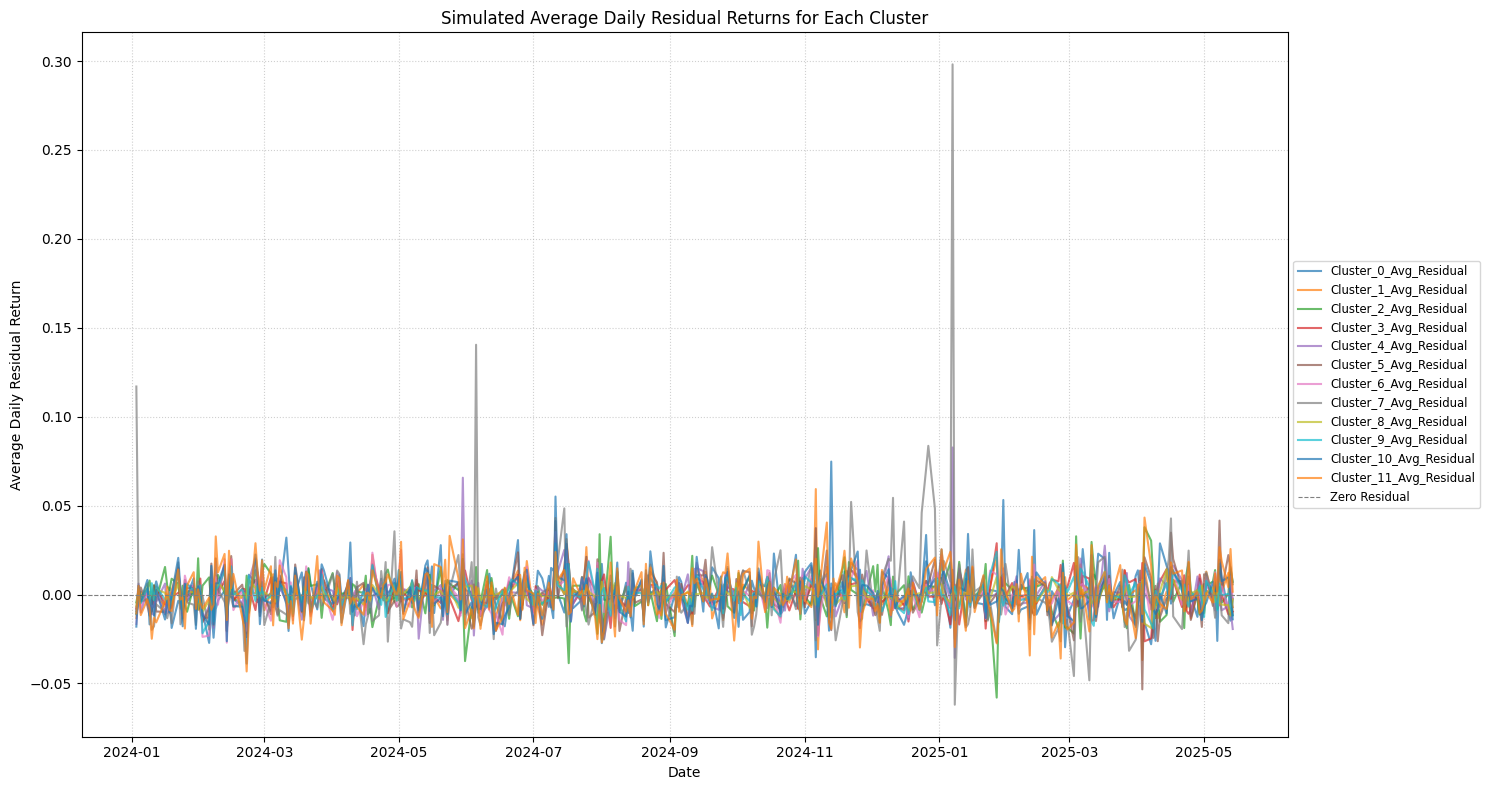

In [166]:
plt.figure(figsize=(15, 8))
for col in cluster_daily_avg_residuals.columns:
    plt.plot(cluster_daily_avg_residuals.index, cluster_daily_avg_residuals[col], label=col, alpha=0.7)

plt.title('Simulated Average Daily Residual Returns for Each Cluster')
plt.xlabel('Date')
plt.ylabel('Average Daily Residual Return')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8, label='Zero Residual')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

In [167]:
merged_tsne[merged_tsne['clusters'] == 7]

,Symbol,PC1,PC2,clusters,Sector,Name
3,ABAT,-5.815246,39.019760,7,Basic Materials,American Battery Technology Company Common Stock
9,ADN,-1.447508,28.510715,7,Miscellaneous,Advent Technologies Holdings Inc. Class A Comm...
32,AMPG,-7.285765,30.131771,7,Telecommunications,Amplitech Group Inc. Common Stock
33,AMPGW,-6.210936,29.722990,7,Telecommunications,Amplitech Group Inc. Warrants
36,ANNA,-6.730616,32.718262,7,Energy,AleAnna Inc. Class A Common Stock
43,AREC,-2.739891,24.627361,7,Energy,American Resources Corporation Class A Common ...
47,ASNS,-4.990067,38.891563,7,Telecommunications,Actelis Networks Inc. Common Stock
48,ASTS,-3.884295,27.014725,7,Consumer Discretionary,AST SpaceMobile Inc. Class A Common Stock
51,AVAV,0.059966,28.153124,7,Industrials,AeroVironment Inc. Common Stock
54,AXON,-1.523586,34.154713,7,Industrials,Axon Enterprise Inc. Common Stock


In [168]:
# Validating our thesis using Silhouette Score and Davies-Bouldin Index or Calinski-Harabasz Index
# Find the best cluster numbers by finding the optimal metrics

In [169]:
pc_scores = df_tsne.get(['PC1', 'PC2', 'Symbol']).set_index('Symbol')
sil_score = silhouette_score(pc_scores, tsne_clusters_aligned['cluster_label'])
dbi_score = davies_bouldin_score(pc_scores, tsne_clusters_aligned['cluster_label'])
chi_score = calinski_harabasz_score(pc_scores, tsne_clusters_aligned['cluster_label'])
print(sil_score, dbi_score, chi_score)

0.48929796 0.697925981376205 948.6488


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



In [170]:
# run a for loop to find out the ideal number of clusters from 1 - 15
num_cluster = []
sil = []
dbi = []
chi = []

for i in range(2, 20):
    n_cluster = i
    print(f'Current cluster {i:}')
    pca_model = PCA(n_components=n_pca_component)
    pca_output = pca_model.fit_transform(resid_corr.values)
    tsne = TSNE(n_components=n_tsne_component, perplexity=15, init='random', random_state=42)
    embedding = tsne.fit_transform(pca_output)
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding)
    df_tsne = pd.DataFrame({
    'Symbol': ticker,
    'PC1': embedding[:,0],
    'PC2': embedding[:,1],
    'clusters': cluster_labels
    })
    pc_scores = df_tsne.get(['PC1', 'PC2', 'Symbol']).set_index('Symbol')
    corr_cluster = df_tsne['clusters']
    sil_score = silhouette_score(pc_scores, corr_cluster)
    dbi_score = davies_bouldin_score(pc_scores, corr_cluster)
    chi_score = calinski_harabasz_score(pc_scores, corr_cluster)
    print(sil_score, dbi_score, chi_score)
    num_cluster.append(i)
    dbi.append(dbi_score)
    chi.append(chi_score)
    sil.append(sil_score)

test_results = pd.DataFrame({
    'num_cluster': num_cluster,
    'sil': sil,
    'dbi': dbi,
    'chi': chi
    })
test_results
    

Current cluster 2


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.47189322 0.828144547466918 618.5098
Current cluster 3


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.40184534 0.9102994274659982 534.6295
Current cluster 4


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.4064369 0.8780870783599725 616.9806
Current cluster 5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.44582552 0.7784507543638802 668.1983
Current cluster 6


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.4450809 0.770267150819687 700.05865
Current cluster 7


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.46375886 0.6967809330826252 693.72284
Current cluster 8


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.47063318 0.6617848854129602 777.81464
Current cluster 9


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.48457047 0.6838427337908044 869.4041
Current cluster 10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.47044683 0.7086003028226082 863.7737
Current cluster 11


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.47175172 0.7284406355206007 902.8411
Current cluster 12


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.48929796 0.697925981376205 948.6488
Current cluster 13


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.49103627 0.6928914859866502 938.431
Current cluster 14


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.48901346 0.6921713261267267 931.0299
Current cluster 15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.47427735 0.6904107994621408 914.354
Current cluster 16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.46669495 0.7019541677710817 930.3311
Current cluster 17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.4637299 0.6964114998803347 959.5529
Current cluster 18


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



0.46809658 0.6965188678701849 979.5918
Current cluster 19
0.47658843 0.7005065386901448 1033.9427


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



,num_cluster,sil,dbi,chi
0,2,0.471893,0.828145,618.509827
1,3,0.401845,0.910299,534.629517
2,4,0.406437,0.878087,616.980591
3,5,0.445826,0.778451,668.198303
4,6,0.445081,0.770267,700.058655
5,7,0.463759,0.696781,693.722839
6,8,0.470633,0.661785,777.814636
7,9,0.484570,0.683843,869.404114
8,10,0.470447,0.708600,863.773682
9,11,0.471752,0.728441,902.841125


In [171]:
resid_corr

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
AAL,1.000000,0.045487,0.013940,0.062087,0.166405,0.018780,0.112186,-0.015802,0.123421,-0.038666,...,-0.015179,-0.021215,0.030480,0.231893,0.111321,-0.093232,0.034995,0.206322,0.033978,-0.027073
AAON,0.045487,1.000000,-0.244485,0.006797,-0.100677,0.032723,0.121121,-0.064526,-0.042473,-0.002442,...,0.004189,0.018463,0.014137,0.128257,0.110078,0.001088,0.012347,0.072648,0.034495,0.071909
AAPL,0.013940,-0.244485,1.000000,0.022736,0.032831,0.009755,0.022072,-0.025251,0.022509,-0.025850,...,-0.020584,-0.009894,-0.016633,-0.035815,0.020581,0.079602,-0.017742,-0.110755,0.007773,0.002507
ABAT,0.062087,0.006797,0.022736,1.000000,0.026815,0.017245,-0.000058,-0.005761,0.006238,0.100489,...,-0.055443,-0.002327,0.016923,0.018469,0.041217,-0.000568,0.021040,-0.000368,0.097028,0.008665
ABNB,0.166405,-0.100677,0.032831,0.026815,1.000000,-0.030687,0.032206,0.068934,0.120943,0.024653,...,0.230475,-0.074383,0.092531,0.137449,-0.019965,0.051326,0.104024,0.036202,0.112238,-0.008373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEO,-0.093232,0.001088,0.079602,-0.000568,0.051326,0.000623,-0.008191,0.052408,0.087195,0.053508,...,0.074813,-0.019883,0.054418,0.010211,-0.028127,1.000000,0.043804,0.065110,0.001231,-0.009860
ZG,0.034995,0.012347,-0.017742,0.021040,0.104024,-0.063113,-0.023237,0.071467,-0.058643,0.162917,...,-0.016456,0.050418,0.994947,0.030787,0.131158,0.043804,1.000000,-0.016126,0.086628,0.050909
ZION,0.206322,0.072648,-0.110755,-0.000368,0.036202,0.201502,0.249320,-0.072213,0.061608,0.052685,...,-0.071120,0.188690,-0.010364,0.299802,0.265550,0.065110,-0.016126,1.000000,0.103131,0.085398
ZM,0.033978,0.034495,0.007773,0.097028,0.112238,0.072688,0.072347,0.096368,0.000774,0.082414,...,-0.004736,0.047405,0.082223,0.028048,0.214495,0.001231,0.086628,0.103131,1.000000,0.265072


In [ ]:
# define our parameter range (DONT RUN THIS CODE AGAIN TOOK 20 MIN)
pca_n_components_range = list(range(2, 20)) # Example range based on prior PCA analysis
tsne_output_n_components_range = [2, 3] # Usually 2 or 3 for t-SNE output
perplexity_range = list(range(5, 50)) # Example common perplexity values
kmeans_n_clusters_range = list(range(2, 20)) # Your range for optimal clusters

results_list = [] # To store results from each combination

for pca_comp in pca_n_components_range:
    pca_model = PCA(n_components=pca_comp, random_state=42)
    pca_output = pca_model.fit_transform(resid_corr)

    for tsne_dim in tsne_output_n_components_range:
        for perp in perplexity_range:
            try:
                tsne_model = TSNE(n_components=tsne_dim, perplexity=perp, init='pca', random_state=42, learning_rate='auto', n_jobs=-1)
                embedding = tsne_model.fit_transform(pca_output)
            except Exception as e:
                print(f"    t-SNE failed for perp={perp}, dim={tsne_dim}: {e}. Skipping combination.")
                continue # Skip to next iteration if t-SNE fails
            for k in kmeans_n_clusters_range:
                kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
                cluster_labels = kmeans_model.fit_predict(embedding)

                silhouette = silhouette_score(embedding, cluster_labels)
                dbi = davies_bouldin_score(embedding, cluster_labels)
                chi = calinski_harabasz_score(embedding, cluster_labels)

                results_list.append({
                    'n_pca': pca_comp,
                    'n_tsne_out_dim': tsne_dim,
                    'perplexity': perp,
                    'n_clusters': k,
                    'silhouette': silhouette,
                    'dbi': dbi,
                    'chi': chi
                })

results_df = pd.DataFrame(results_list)
results_df
    

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

KeyboardInterrupt: 

In [172]:
results_df

,n_pca,n_tsne_out_dim,perplexity,n_clusters,silhouette,dbi,chi
0,2,2,5,2,0.386924,1.041787,384.525146
1,2,2,5,3,0.422164,0.817850,493.347748
2,2,2,5,4,0.396048,0.847902,475.680908
3,2,2,5,5,0.398317,0.822860,502.305359
4,2,2,5,6,0.420601,0.819723,529.060242
...,...,...,...,...,...,...,...
28345,19,3,49,15,0.267576,1.059406,207.198868
28346,19,3,49,16,0.260598,1.061124,202.402725
28347,19,3,49,17,0.259151,1.070077,198.370529
28348,19,3,49,18,0.264949,1.056411,200.000412


In [173]:
# Find the best combination based on Silhouette Score
best_silhouette = results_df.sort_values(by='silhouette', ascending=False).head(5)
print("\nTop 5 combinations by Silhouette Score:")
print(best_silhouette)

# Find the best combination based on Davies-Bouldin Index
best_dbi = results_df.sort_values(by='dbi', ascending=True).head(5)
print("\nTop 5 combinations by Davies-Bouldin Index:")
print(best_dbi)



Top 5 combinations by Silhouette Score:
       n_pca  n_tsne_out_dim  perplexity  n_clusters  silhouette       dbi  \
4518       5               2          31           2    0.548968  0.640952   
4806       5               2          47           2    0.530278  0.683828   
9234       8               2          23           2    0.527599  0.680356   
25668     18               2          36           2    0.523834  0.698080   
23922     17               2          29           2    0.523437  0.675581   

               chi  
4518   1015.440308  
4806    906.510803  
9234    901.908752  
25668   837.454956  
23922   892.210022  

Top 5 combinations by Davies-Bouldin Index:
      n_pca  n_tsne_out_dim  perplexity  n_clusters  silhouette       dbi  \
4083      5               2           6          17    0.505591  0.593673   
34        2               2           6          18    0.514984  0.609489   
35        2               2           6          19    0.510539  0.614292   
5698      6

In [174]:
# Find the best combination based on Calinski-Harabasz Index
best_chi = results_df.sort_values(by='chi', ascending=False).head(5)
print("\nTop 5 combinations by Calinski-Harabasz Index:")
print(best_chi)


Top 5 combinations by Calinski-Harabasz Index:
      n_pca  n_tsne_out_dim  perplexity  n_clusters  silhouette       dbi  \
4535      5               2          31          19    0.429029  0.736517   
4532      5               2          31          16    0.438565  0.723136   
4534      5               2          31          18    0.424886  0.743360   
4530      5               2          31          14    0.430722  0.739314   
4531      5               2          31          15    0.425246  0.752214   

              chi  
4535  1073.268921  
4532  1068.453735  
4534  1068.173462  
4530  1066.485107  
4531  1063.077515  


In [96]:
# bootstrap the sample to see if my cluster would change using a different sample size
optimal_n_pca_components = 5
optimal_tsne_output_dim = 2 
optimal_perplexity = 30            
optimal_n_clusters = 12


def run_clustering_pipeline(data_input, n_pca, tsne_dim, perp, n_clusters, random_seed_val):
    # Ensure data_input is a NumPy array for consistency
    data_input_arr = data_input.values if isinstance(data_input, pd.DataFrame) else data_input

    # PCA
    pca_model = PCA(n_components=n_pca, random_state=random_seed_val)
    pca_output = pca_model.fit_transform(data_input_arr)

    # t-SNE
    # Note: init='pca' is often more stable for t-SNE when using PCA output
    # Also, ensure learning_rate='auto' if sklearn version >= 1.0
    tsne_model = TSNE(n_components=tsne_dim, perplexity=perp, init='pca',
                      random_state=random_seed_val, learning_rate='auto', n_jobs=-1)
    embedding = tsne_model.fit_transform(pca_output)

    # KMeans
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=random_seed_val, n_init=10)
    cluster_labels = kmeans_model.fit_predict(embedding)

    return cluster_labels, embedding

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

  Iteration 10 complete. Current mean ARI: 0.4538


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

  Iteration 20 complete. Current mean ARI: 0.4529


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

  Iteration 30 complete. Current mean ARI: 0.4516


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

  Iteration 40 complete. Current mean ARI: 0.4434


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

  Iteration 50 complete. Current mean ARI: 0.4464


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

  Iteration 60 complete. Current mean ARI: 0.4477


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

  Iteration 70 complete. Current mean ARI: 0.4455


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

  Iteration 80 complete. Current mean ARI: 0.4442


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

  Iteration 90 complete. Current mean ARI: 0.4431


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

  Iteration 100 complete. Current mean ARI: 0.4390

Bootstrap analysis complete.

--- Bootstrap Clustering Stability Results (n=100 iterations) ---
Mean Adjusted Rand Index (ARI): 0.4390
Standard Deviation of ARI:      0.0506
Minimum ARI:                    0.3240
Maximum ARI:                    0.5691


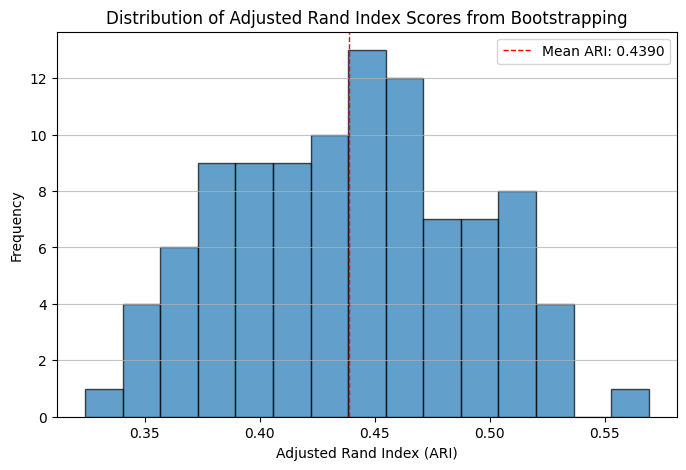

Interpretation: Moderate clustering stability. Clusters show some sensitivity to sampling.


In [175]:
original_stock_indices = resid_corr.index # This is crucial for tracking samples
original_data_values = resid_corr.values

original_cluster_labels, original_embedding = run_clustering_pipeline(
    data_input=original_data_values,
    n_pca=optimal_n_pca_components,
    tsne_dim=optimal_tsne_output_dim,
    perp=optimal_perplexity,
    n_clusters=optimal_n_clusters,
    random_seed_val=42 
)

original_labels_series = pd.Series(original_cluster_labels, index=original_stock_indices)


num_bootstrap_iterations = 100 # A common number, increase for more robust results
bootstrap_ari_scores = []

for i in range(num_bootstrap_iterations):
    # Generate bootstrap sample indices (sampling with replacement)
    # We sample the *indices* of the original data to preserve identity
    bootstrap_indices_sampled = np.random.choice(
        original_stock_indices, # Choose from original indices
        size=len(original_stock_indices), # Same size as original
        replace=True # With replacement
    )

    # Create the bootstrap data (use .loc if original is DataFrame, direct indexing if NumPy array)
    # This creates a new matrix with some rows duplicated and some omitted.
    bootstrap_data_values = resid_corr.loc[bootstrap_indices_sampled].values
    # Note: The order of rows in bootstrap_data_values corresponds to bootstrap_indices_sampled

    # Run the clustering pipeline on the bootstrap sample
    # IMPORTANT: Use a consistent random_state for reproducibility within each bootstrap run,
    # or vary it if you want to test sensitivity to algorithmic randomness too.
    # Keeping it fixed (e.g., i for each iter) is usually good for stability testing.
    bootstrap_labels, _ = run_clustering_pipeline(
        data_input=bootstrap_data_values,
        n_pca=optimal_n_pca_components,
        tsne_dim=optimal_tsne_output_dim,
        perp=optimal_perplexity,
        n_clusters=optimal_n_clusters,
        random_seed_val=i # Vary random state per iteration
    )
    # Store bootstrap labels with their corresponding indices (from bootstrap_indices_sampled)
    bootstrap_labels_series = pd.Series(bootstrap_labels, index=bootstrap_indices_sampled)

    # --- Align samples for comparison ---
    # Find stocks that are present in both the original and this bootstrap sample
    # Note: A stock can appear multiple times in bootstrap_labels_series due to replacement.
    # We need to ensure we compare based on unique original identities.

    # Get unique original stock IDs that appear in this bootstrap sample
    unique_original_stocks_in_bootstrap = bootstrap_labels_series.index.unique()

    # Filter for common stocks between original and this bootstrap sample
    common_stocks = original_labels_series.index.intersection(unique_original_stocks_in_bootstrap)

    if len(common_stocks) > 1: # Need at least 2 common samples for ARI
        # Get the reference labels for only these common stocks
        ref_labels_for_ari = original_labels_series.loc[common_stocks]

        # Get the bootstrap labels for these common stocks.
        # If a stock was duplicated in bootstrap_indices_sampled, its label will appear multiple times.
        # We need to take a single label for each unique common stock from the bootstrap result.
        # A common way is to take the mode (most frequent label) if a stock appears multiple times,
        # or just the first one if we assume consistency. For simplicity, let's align by index
        # and ensure unique indices for comparison.

        # Create a Series of labels for common stocks from the bootstrap result.
        # This requires careful re-indexing if bootstrap_labels_series has duplicates.
        # A robust way is to re-run the pipeline on *just the unique common stocks*
        # if cluster labels must be exactly from one run, or average.
        # More commonly for ARI, we just use the first instance's label if duplicates exist in bootstrap.
        # Simpler approach: Map the labels back to original common_stocks order

        # To handle duplicates in bootstrap_labels_series (from `np.random.choice(..., replace=True)`):
        # For ARI, we need a single label for each unique sample.
        # If a stock appears multiple times in the bootstrap sample, it will have multiple labels.
        # The most straightforward way is to take the *first* label assigned to it if it was duplicated,
        # OR consider only unique stocks that appeared in the bootstrap sample.

        # Let's align by getting the unique indices of the bootstrap sample, then intersect with original.
        # And take the first label for each unique stock in the bootstrap result.
        aligned_bootstrap_labels = bootstrap_labels_series.groupby(level=0).first().loc[common_stocks] # Get first label for each unique stock

        # Calculate ARI
        ari_score = adjusted_rand_score(ref_labels_for_ari, aligned_bootstrap_labels)
        bootstrap_ari_scores.append(ari_score)
    else:
        print(f"  Iteration {i+1}: Not enough common samples ({len(common_stocks)}) for ARI calculation. Skipping.")

    if (i + 1) % 10 == 0:
        print(f"  Iteration {i+1} complete. Current mean ARI: {np.mean(bootstrap_ari_scores):.4f}")

print("\nBootstrap analysis complete.")

# --- 4. Analyze Results ---
if bootstrap_ari_scores:
    mean_ari = np.mean(bootstrap_ari_scores)
    std_ari = np.std(bootstrap_ari_scores)
    min_ari = np.min(bootstrap_ari_scores)
    max_ari = np.max(bootstrap_ari_scores)

    print(f"\n--- Bootstrap Clustering Stability Results (n={num_bootstrap_iterations} iterations) ---")
    print(f"Mean Adjusted Rand Index (ARI): {mean_ari:.4f}")
    print(f"Standard Deviation of ARI:      {std_ari:.4f}")
    print(f"Minimum ARI:                    {min_ari:.4f}")
    print(f"Maximum ARI:                    {max_ari:.4f}")

    plt.figure(figsize=(8, 5))
    plt.hist(bootstrap_ari_scores, bins=15, edgecolor='black', alpha=0.7)
    plt.axvline(mean_ari, color='red', linestyle='dashed', linewidth=1, label=f'Mean ARI: {mean_ari:.4f}')
    plt.title('Distribution of Adjusted Rand Index Scores from Bootstrapping')
    plt.xlabel('Adjusted Rand Index (ARI)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Interpretation:
    if mean_ari > 0.8:
        print("Interpretation: Very strong clustering stability. Clusters are highly robust to sampling variations.")
    elif mean_ari > 0.6:
        print("Interpretation: Good clustering stability. Clusters are reasonably robust.")
    elif mean_ari > 0.4:
        print("Interpretation: Moderate clustering stability. Clusters show some sensitivity to sampling.")
    else:
        print("Interpretation: Low clustering stability. Clusters are highly dependent on the specific sample.")

else:
    print("No ARI scores were calculated. Check common sample filtering.")


In [176]:
residuals

,AAL,AAON,AAPL,ABAT,ABNB,ACDC,ACTG,ADBE,ADI,ADN,...,XPON,YORW,Z,ZBRA,ZD,ZEO,ZG,ZION,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,-0.022897,0.000043,0.002564,-0.026922,0.003487,0.012460,-0.000332,-0.004594,-0.010152,-0.067865,...,0.041304,-0.014400,-0.024295,-0.044985,-0.008836,0.005463,-0.028755,-0.038437,-0.022029,0.002227
2024-01-04,0.017157,0.012896,-0.008255,0.011023,0.007439,-0.031574,-0.014615,-0.003275,-0.009234,-0.024929,...,0.042179,-0.009667,-0.014688,0.007464,0.002507,0.000955,-0.018066,0.019600,-0.001287,0.005805
2024-01-05,0.037044,-0.020608,-0.005988,-0.024692,0.015015,0.044464,0.004102,-0.004650,-0.000127,-0.016518,...,0.003216,-0.009340,-0.010841,-0.003468,-0.005979,-0.000271,-0.008640,0.030920,-0.000805,-0.004974
2024-01-08,0.050816,-0.003150,0.007183,-0.025832,0.011715,-0.032475,0.001332,0.015422,-0.010183,0.001266,...,-0.022613,0.006452,0.017076,0.012067,0.007617,-0.004325,0.021375,-0.006248,0.009283,0.018583
2024-01-09,-0.010439,-0.012306,-0.000202,-0.003755,-0.001363,-0.011415,0.001705,0.012763,0.006933,0.009199,...,0.037352,-0.010476,-0.002126,-0.015114,-0.013858,0.001058,-0.002202,-0.009281,-0.000084,0.039866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,0.036341,0.030163,-0.000513,0.045436,0.019321,-0.068335,0.148548,-0.006917,0.005273,-0.008212,...,0.067418,-0.014756,-0.007698,0.022999,0.018965,-0.032172,-0.003424,0.023332,0.015417,-0.010131
2025-05-09,0.009326,0.008502,0.006391,-0.004654,0.006674,0.109128,0.066018,0.000402,0.024853,-0.162722,...,0.112443,0.003528,0.001395,0.006572,-0.041920,0.044499,0.001398,-0.004564,0.013648,0.000917
2025-05-12,0.000156,-0.002454,0.023617,-0.087636,0.013161,0.061128,0.004298,0.001445,0.021388,-0.028678,...,-0.049055,-0.022907,0.003530,0.075818,0.084065,-0.072509,0.004181,0.023205,-0.010913,-0.012458


In [137]:
residuals

""
Date
2018-01-01
2018-01-02
2018-01-03
2018-01-04
2018-01-05
...
2023-12-25
2023-12-26
2023-12-27
